# Advanced Image Processing and Text Recognition with Spark OCR

In [0]:
from johnsnowlabs import nlp,medical,visual

In [0]:
import pkg_resources
import pandas as pd
import numpy as np
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

## Image (or Natural Scene) to Text

# Pdf to Text

In [0]:
!wget -q -O sample_doc.pdf http://www.asx.com.au/asxpdf/20171103/pdf/43nyyw9r820c6r.pdf
dbutils.fs.cp("file:/databricks/driver/sample_doc.pdf", "dbfs:/")

True

In [0]:
def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_image = visual.PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")

    # Run OCR
    ocr = visual.ImageToText()\
          .setInputCol("image")\
          .setOutputCol("text")\
          .setConfidenceThreshold(65)
    
    pipeline = nlp.PipelineModel(stages=[
        pdf_to_image,
        ocr
    ])
    
    return pipeline

In [0]:
pdf = '/sample_doc.pdf'
pdf_example_df = spark.read.format("binaryFile").load(pdf).cache()
display(pdf_example_df)

path modificationTime length content dbfs:/sample_doc.pdf 2023-11-01T09:09:10Z 212973 JVBERi0xLjUNJeLjz9MNCjUgMCBvYmoNPDwvRSAyMTIyMjEvSCBbIDEwODEgMTQ1IF0vTCAyMTI5NzMvTGluZWFyaXplZCAxL04gMS9PIDgvVCAyMTI1NTM+Pg1lbmRvYmoNICAgICAgICAgICAgICAgICAgICAgICAgICAgDQ0= (truncated)

In [0]:
result = pipeline().transform(pdf_example_df).cache()

In [0]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|ASX ANNOUNCEMENT\...|89.37777921888564|
+-------+--------------------+-----------------+



In [0]:
result.select("text").collect()

[Row(text='ASX ANNOUNCEMENT\n3 November 2017\n\nNotice Pursuant to Paragraph 708A(5)(e) of the Corporations Act\n2001 ("Act")\n\nDigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today\nissued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted\nOptions exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon\nexercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February\n2018.\n\nThe Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt\nunder section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above\nwill fall within the exemption in section 708A(5) of the Act.\n\nThe Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:\n(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of\nthe Act;\n(b) as at the date of this notice, the Company has complied with the provisions of 

In [0]:
print("\n".join([row.text for row in result.select("text").collect()]))


ASX ANNOUNCEMENT
3 November 2017

Notice Pursuant to Paragraph 708A(5)(e) of the Corporations Act
2001 ("Act")

DigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today
issued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted
Options exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon
exercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February
2018.

The Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt
under section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above
will fall within the exemption in section 708A(5) of the Act.

The Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:
(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of
the Act;
(b) as at the date of this notice, the Company has complied with the provisions of Chapter
2M of the Act as they 

##  With Skew Correction

In [0]:
from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt

In [0]:
def ocr_pipeline(skew_correction=False):
    
    # Transforrm PDF document to images per page
    pdf_to_image = visual.PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")

    # Image skew corrector 
    skew_corrector = visual.ImageSkewCorrector()\
          .setInputCol("image")\
          .setOutputCol("corrected_image")\
          .setAutomaticSkewCorrection(skew_correction)

    # Run OCR
    ocr = visual.ImageToText()\
          .setInputCol("corrected_image")\
          .setOutputCol("text")
    
    pipeline = visual.PipelineModel(stages=[
        pdf_to_image,
        skew_corrector,
        ocr
    ])
    
    return pipeline

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/400_rot.pdf
dbutils.fs.cp("file:/databricks/driver/400_rot.pdf", "dbfs:/")

True

In [0]:
pdf_rotated_df = spark.read.format("binaryFile").load('/400_rot.pdf').cache()

In [0]:
pdf_pipeline = ocr_pipeline(False) 

result = pdf_pipeline.transform(pdf_rotated_df).cache()


In [0]:
result.show()

+-----------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+
|             path|   modificationTime| length|               image|total_pages|pagenum|documentnum|     corrected_image|       confidence|exception|                text|           positions|
+-----------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+
|dbfs:/400_rot.pdf|2023-11-01 09:11:21|2240141|{dbfs:/400_rot.pd...|          1|      0|          0|{dbfs:/400_rot.pd...|95.66203460693359|         |FOREWORD\n\nElect...|[{[{FOREWORD\n\n,...|
+-----------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+



In [0]:
result.select("pagenum").collect()[0].pagenum

0

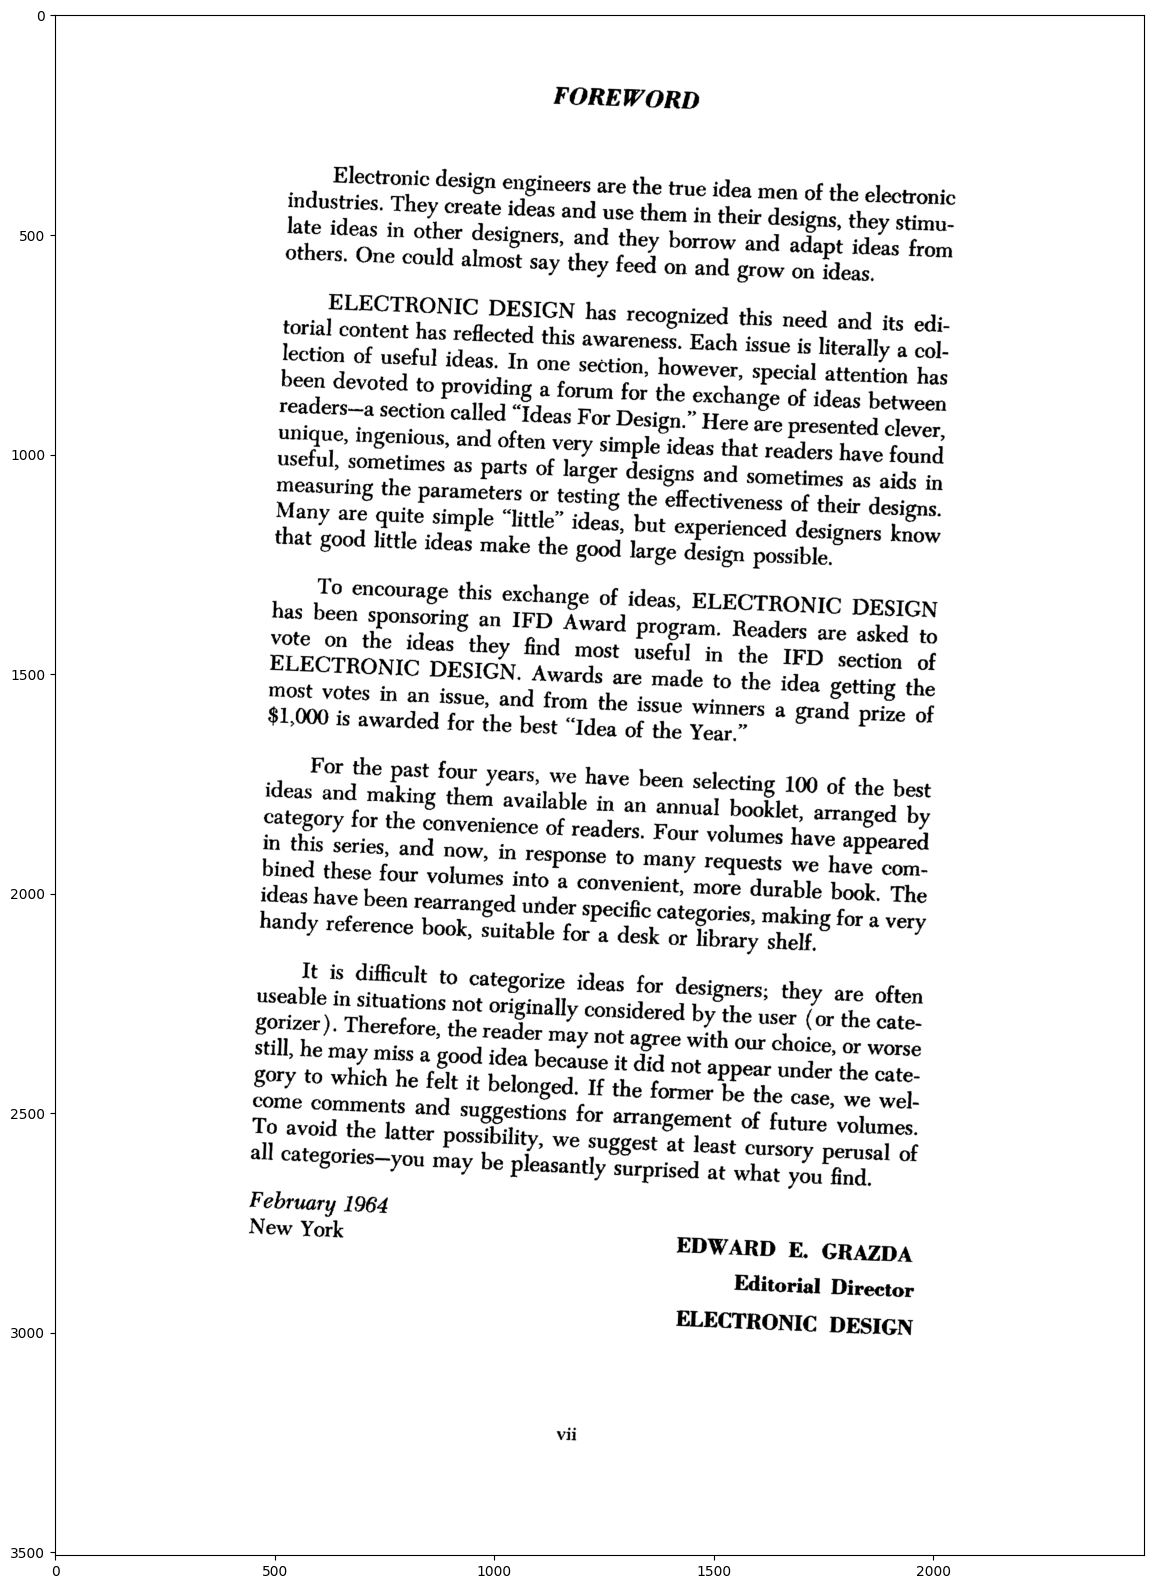

In [0]:
img = result.select("image").collect()[0].image
img_pil = visual.to_pil_image(img, img.mode)

plt.figure(figsize=(30,20))
plt.imshow(img_pil, cmap='gray')
plt.show()

## Display recognized text without skew correction

In [0]:
result.select("pagenum","text", "confidence").show()


+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD\n\nElect...|95.66203460693359|
+-------+--------------------+-----------------+



In [0]:
print("\n".join([row.text for row in result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

To encourage this exchange of ideas, ELECTRONIC DESIGN
has been sponsoring an IFD Award program. Readers are asked to
vote on the ideas they find most useful in the IFD section of

most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

handy reference book, suitable for a desk or library shelf,

It is difficult to categorize ideas for designers; they are often
useable in situations not originally considered by the user (or the cate-

come comments and suggestions for arrangement of future volumes.
To avoid the latter possibility, we Suggest at least cursory perusal of
all categories—you may be pleasantly surprised at what you find.

February 1964

## Display results with skew correction

In [0]:
pdf_pipeline = ocr_pipeline(True) 

corrected_result = pdf_pipeline.transform(pdf_rotated_df).cache()

print("\n".join([row.text for row in corrected_result.select("text").collect()]))


FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id

In [0]:
corrected_result.select("pagenum","text", "confidence").show(truncate=50)


+-------+--------------------------------------------------+-----------------+
|pagenum|                                              text|       confidence|
+-------+--------------------------------------------------+-----------------+
|      0|FOREWORD\n\nElectronic design engineers are the...|93.92264418168502|
+-------+--------------------------------------------------+-----------------+



## Display skew corrected images

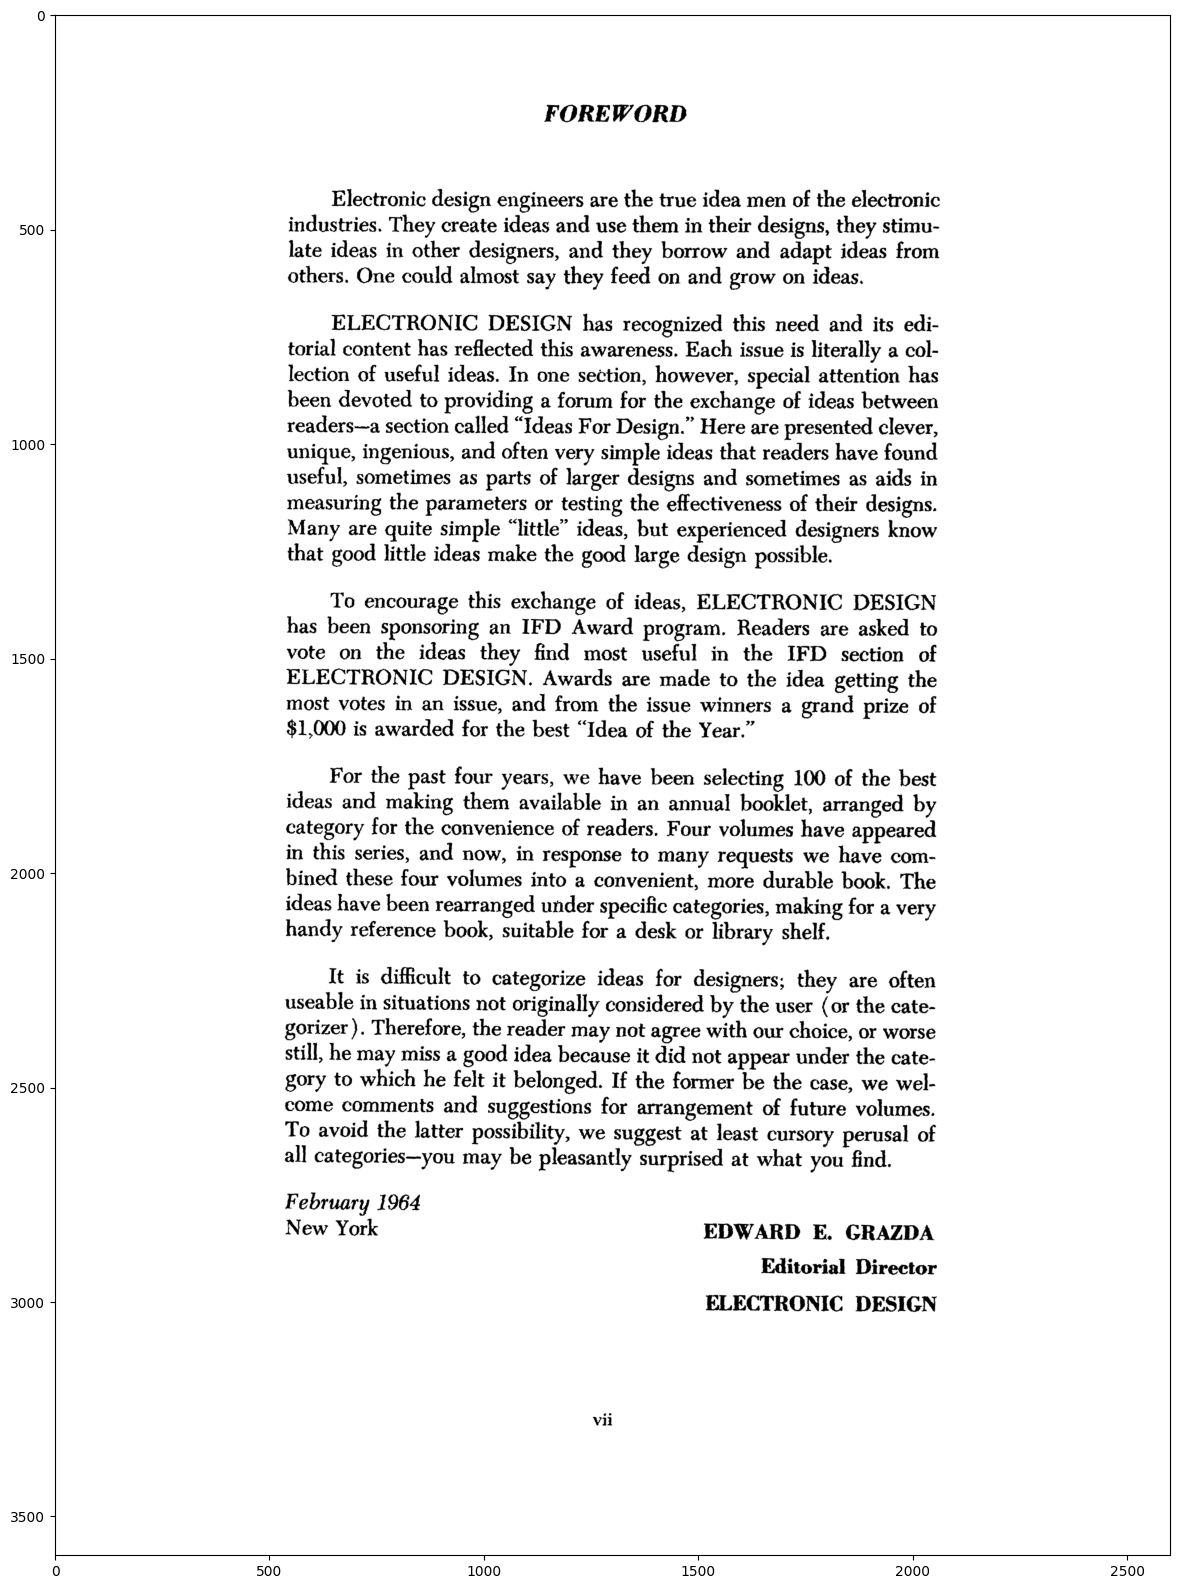

In [0]:
img = corrected_result.select("corrected_image").collect()[0].corrected_image
img_pil = visual.to_pil_image(img, img.mode)

plt.figure(figsize=(30,20))
plt.imshow(img_pil, cmap='gray')
plt.show()

## Compute score and compare
Read original text and calculate scores for both results.

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/400.txt
dbutils.fs.cp("file:/databricks/driver/400.txt", "dbfs:/")

True

In [0]:
detected = "\n".join([row.text for row in result.collect()])
corrected_detected = "\n".join([row.text for row in corrected_result.collect()])

# read original text
pdf_rotated_text = open('400.txt', "r").read()

# compute scores
detected_score = visual.score(pdf_rotated_text, detected)
corrected_score = visual.score(pdf_rotated_text, corrected_detected)

#  print scores
print("Score without skew correction: {0}".format(detected_score))
print("Score with skew correction: {0}".format(corrected_score))

Score without skew correction: 0.5688960515713135
Score with skew correction: 0.952249950874435


## Reading multiple pdfs from folder

In [0]:
pdf_path = "/*.pdf"

pdfs = spark.read.format("binaryFile").load(pdf_path).cache()
#images = spark.read.format("binaryFile").load('text_with_noise.png').cache()

pdfs.count()

12

In [0]:
# Transforrm PDF document to images per page
pdf_to_image = visual.PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = visual.ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

ocr_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])


In [0]:
results = ocr_pipeline.transform(pdfs)


In [0]:
results.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'confidence',
 'exception',
 'text',
 'positions']

In [0]:
results.select('path','confidence','text').show()

+--------------------+--------------------+--------------------+
|                path|          confidence|                text|
+--------------------+--------------------+--------------------+
|     dbfs:/MT_03.pdf|   95.45634460449219|PHYSICAL EXAM:\n\...|
|     dbfs:/MT_00.pdf|   95.49297587076823|from the pericard...|
|dbfs:/test_docume...|    84.6904648674859|Patient Nam\nFina...|
|dbfs:/test_docume...|   83.06709993802585|Patient Name\nFin...|
|     dbfs:/MT_03.pdf|   95.52715894911024|Sample Type / Med...|
|    dbfs:/Result.pdf|-1.79769313486231...|                    |
|   dbfs:/400_rot.pdf|   95.66203460693359|FOREWORD\n\nElect...|
|    dbfs:/noised.pdf|    72.7632067280431| \n\n \n\n \n\nSa...|
|     dbfs:/MT_01.pdf|   55.37715031550481|by Mr. P on 3 7/1...|
| dbfs:/MT_OCR_00.pdf|   94.04216995239258|Sample Type / Med...|
|     dbfs:/MT_02.pdf|    95.4167743259006|Record date : 207...|
|dbfs:/Result_deid...|-1.79769313486231...|                    |
|     dbfs:/MT_00.pdf|   

## Image processing after reading a pdf

In [0]:
from sparkocr.enums import *

# Read binary as image
pdf_to_image = visual.PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image")\
  .setResolution(400)

# Binarize using adaptive tresholding
binarizer = visual.ImageAdaptiveThresholding()\
  .setInputCol("image")\
  .setOutputCol("binarized_image")\
  .setBlockSize(91)\
  .setOffset(50)

# Apply morphology opening
opening = visual.ImageMorphologyOperation()\
  .setKernelShape(KernelShape.SQUARE)\
  .setOperation(MorphologyOperationType.OPENING)\
  .setKernelSize(3)\
  .setInputCol("binarized_image")\
  .setOutputCol("opening_image")

# Remove small objects
remove_objects = visual.ImageRemoveObjects()\
  .setInputCol("opening_image")\
  .setOutputCol("corrected_image")\
  .setMinSizeObject(130)

# Image Layout Analyzer for detect regions
image_layout_analyzer = visual.ImageLayoutAnalyzer()\
  .setInputCol("corrected_image")\
  .setOutputCol("region")\

draw_regions = visual.ImageDrawRegions()\
  .setInputCol("corrected_image")\
  .setInputRegionsCol("region")\
  .setOutputCol("image_with_regions")

# Run tesseract OCR for corrected image
ocr_corrected = visual.ImageToText()\
  .setInputCol("corrected_image")\
  .setOutputCol("corrected_text")\
  .setPositionsCol("corrected_positions")\
  .setConfidenceThreshold(65)

# Run OCR for original image
ocr = visual.ImageToText()\
  .setInputCol("image")\
  .setOutputCol("text")

# OCR pipeline
image_pipeline = PipelineModel(stages=[
    pdf_to_image,
    binarizer,
    opening,
    remove_objects,
    image_layout_analyzer,
    draw_regions,
    ocr,
    ocr_corrected
])

In [0]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/pdfs/noised.pdf
dbutils.fs.cp("file:/databricks/driver/noised.pdf", "dbfs:/")

True

In [0]:
image_df = spark.read.format("binaryFile").load('/noised.pdf').cache()
image_df.show()

+----------------+-------------------+-------+--------------------+
|            path|   modificationTime| length|             content|
+----------------+-------------------+-------+--------------------+
|dbfs:/noised.pdf|2023-11-01 09:17:58|2115939|[25 50 44 46 2D 3...|
+----------------+-------------------+-------+--------------------+



In [0]:
result = image_pipeline.transform(image_df).cache()

In [0]:
#%pip install scikit-image==0.19.3

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.22.0
    Not uninstalling scikit-image at /local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-a18ddfeb-6108-4da3-a663-ae2be54b1ce3
    Can't uninstall 'scikit-image'. No files were found to uninstall.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


Original: dbfs:/noised.pdf
Corrected: dbfs:/noised.pdf


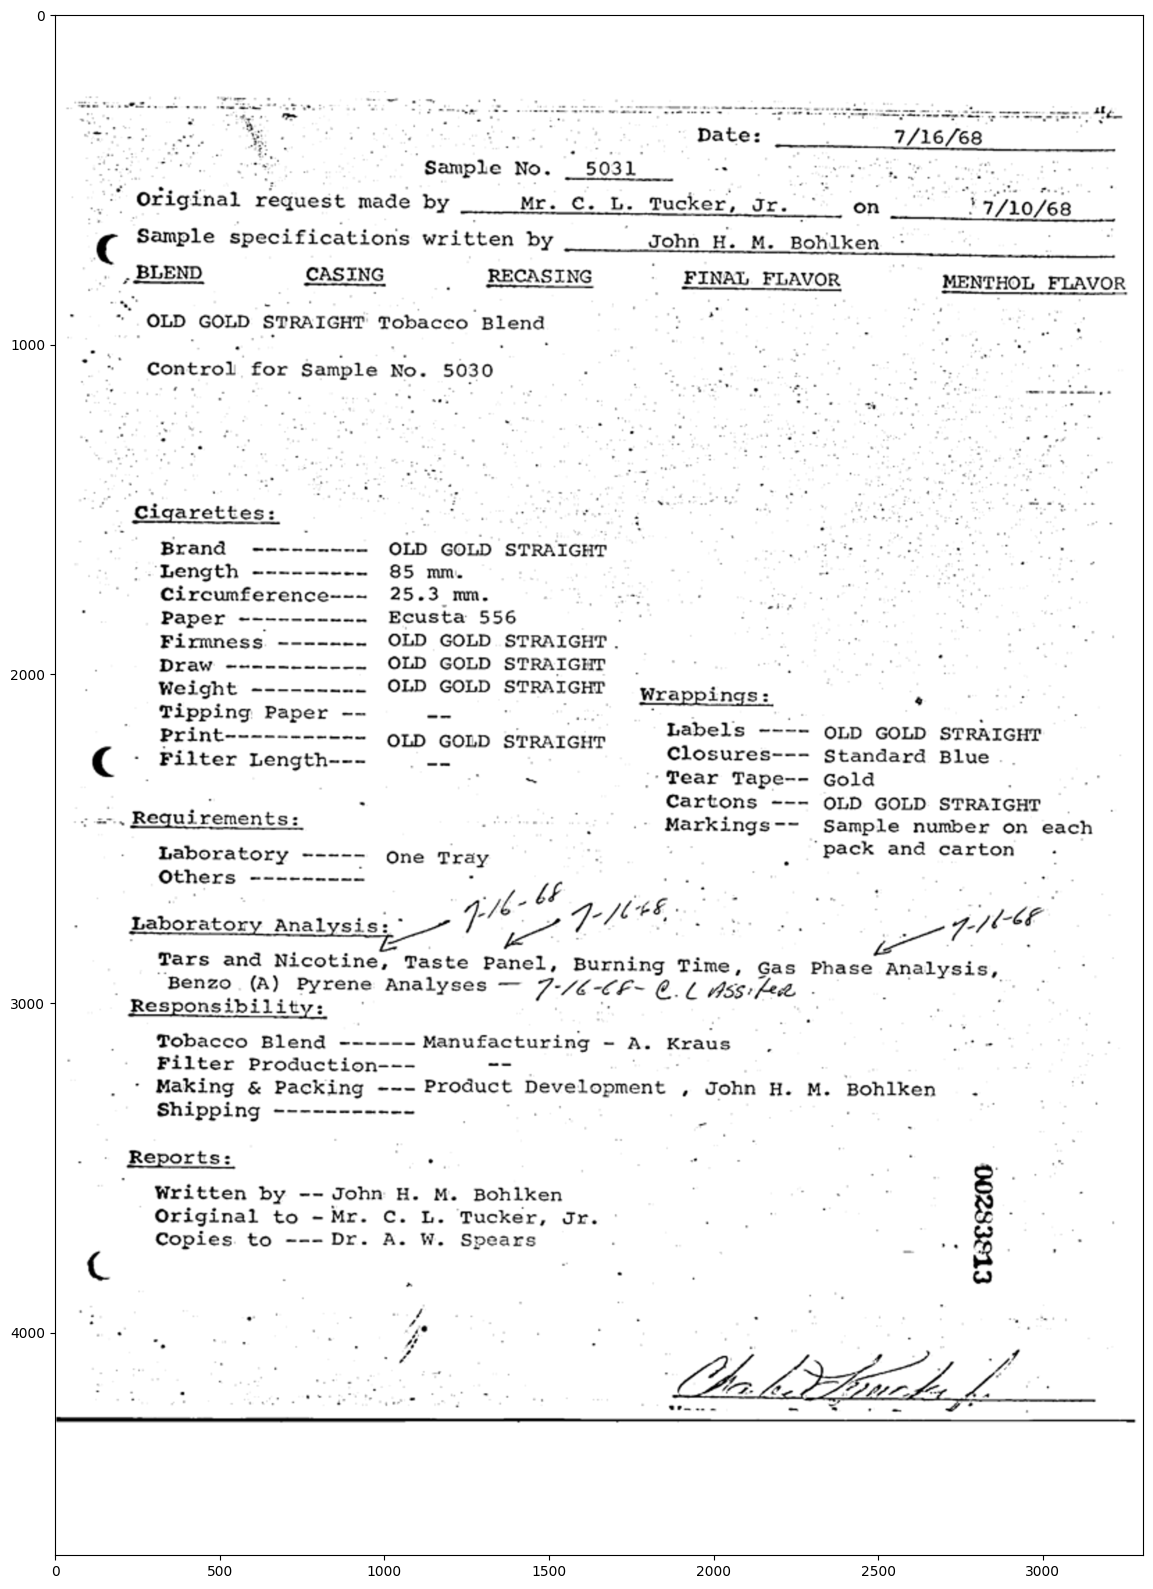

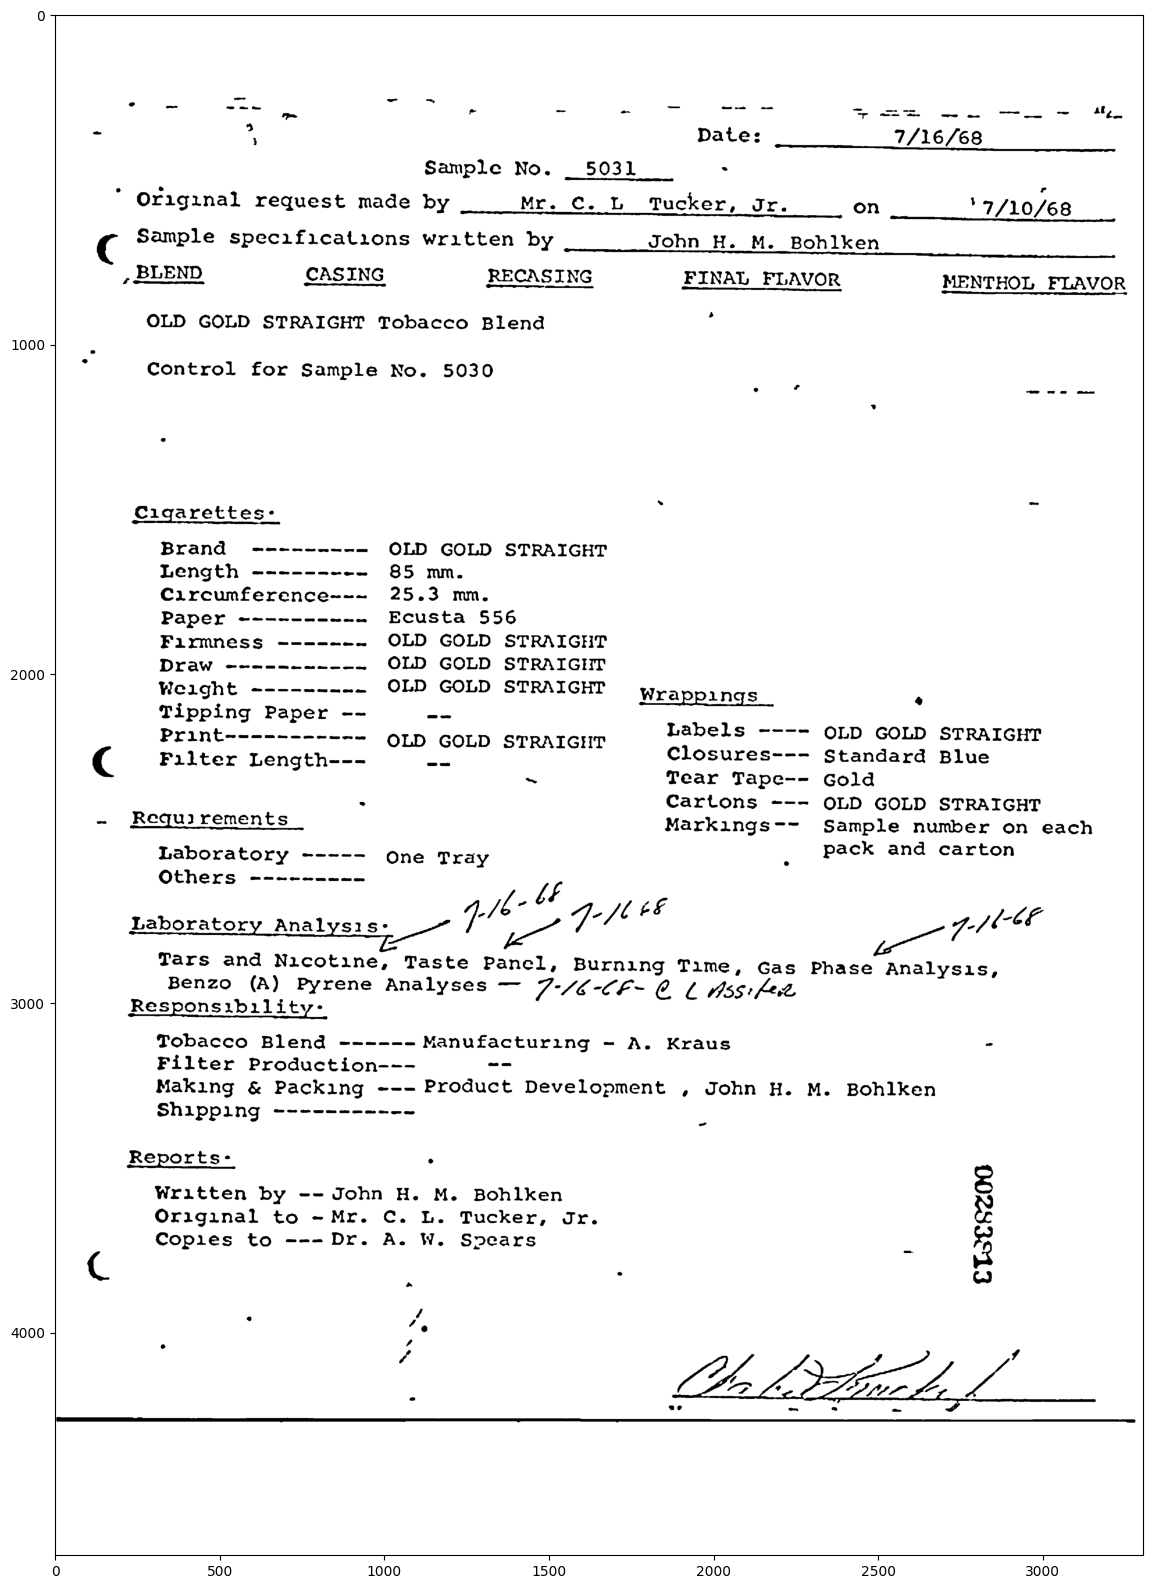

In [0]:
for r in result.distinct().collect():
    
    print("Original: %s" % r.path)
    img = r.image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    print("Corrected: %s" % r.path)
    img = r.corrected_image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    plt.show()

## Results with original image

In [0]:
grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("text")).alias("text"))
for row in grouped_results.collect():
    print("Filename:\n%s , page: %d" % (row.path, row.pagenum))
    print("Recognized text:\n%s" % row.text)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1820801616538676>, line 1
----> 1 grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("text")).alias("text"))
      2 for row in grouped_results.collect():
      3     print("Filename:\n%s , page: %d" % (row.path, row.pagenum))

NameError: name 'F' is not defined

## Results with corrected image

In [0]:
from pyspark.sql import functions as F

In [0]:
grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("corrected_text")).alias("corrected_text"))
for row in grouped_results.collect():
    print("Filename:\n%s , page: %d" % (row.path, row.pagenum))
    print("Recognized text:\n%s" % row.corrected_text)

Filename:
dbfs:/noised.pdf , page: 0
Recognized text:
 

 

 

 

 

2 7 Date: 7/16/68
Sample No. —_ 5031 >
* Oraginal request made by Mr. €. L Tucker, Jr. on ‘7/10/68
Sample specifications written by John H. M. Bohlken
, BLEND CASING RECASING FINAL FLAVOR MENTHOL FLAVOR

 

 

 

OLD GOLD STRAIGHT Tobacco Blend

Control for Sample No. 5030

Cigarettes:

 

 

 

Brand -+--------- OLD GOLD STRAIGHT
Length --------- 85 mm.
Circumference~~-~ 25.3 mm.
Paper eee me meme Ecusta 556
Firymness -----—-. OLD GOLD STRAIGHT
Draw -----~~.~——. OLD GOLD STRAIGHT
Weaght mee eee OLD GOLD STRAIGHT Wrappings ‘
Tipping Paper -- --
Prant-~---------- OLD GOLD STRAIGHT pene “777 OLD GOLD STRAIGHT
Filter Length--- __ sures--- Standard Blue
~ Tear Tape-- Gold
. Cartons --- OLD GOLD STRAIGHT
Requirements Markings-- Sample number on each

Laboratory ----- One Tray . pack and carton
Others ---~--~-----

 

Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — 7-16 -CF- C2 

In [0]:
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'binarized_image',
 'opening_image',
 'corrected_image',
 'region',
 'image_with_regions',
 'confidence',
 'text',
 'positions',
 'confidence',
 'exception',
 'corrected_text',
 'corrected_positions']

## Abby output

In [0]:
abbyy = """-----
% Date: 7/16/68
X*: I; * • ■ Sample No. 5031___ — .*
•* Original request made by _____Mr. C. L. Tucker, Jr. on
Sample specifications written by
BLEND CASING RECASING
OLD GOLD STRAIGHT Tobacco Blend
Control for Sample No. 5030
John H. M. Bohlken
FINAL FLAVOR
) 7/10/68
MENTHOL FLAVOR
• Cigarettes; * . .v\ . /,*, *, S •
Brand --------- OLD GOLD STRAIGHT -V . ••••
; . L e n g t h ------- — 85 mm. . : '
Circumference-- 25.3 mm. • ' *;. • •
P a p e r ---------- Ecusta 556 • * .
F i r m n e s s---- —— OLD GOLD STRAIGHT . ! •■'
D r a w ___________ OLD GOLD STRAIGHT
W e i g h t --------- 0LD GOLD STRAIGHT Wrappings: « -
Tipping Paper — — *
p H n f —. — — _ _ ~ L a b e l s ----OLD GOLD STRAIGHT
( • Filter Length-- . — Closures--- Standard Blue .
^ ^ ; • Tear Tape— Gold
Cartons --- OLD GOLD STRAIGHT
s Requirements: . - •' • Markings-- Sample number on each
• pack and carton Laboratory----- One Tray .
O t h e r s --------- * , s • • . 4
Laboratory A n a l ysis^ I " '/***• * 7 ' ^ ^
Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — J-ZZ-Zf'- (£. / •
Responsibility;
Tobacco B l e n d ------Manufacturing - A. Kraus . . * -
Filter Production--- —
• Making & P a c k i n g---Product Development , John H. M. Bohlken
Shipping -----------
Reports:
t
Written by — John H. M. Bohlken
Original to - Mr. C. L. Tucker, Jr.
Copies t o ---Dr. A. W. Spears
• 9 ..
"""

Original: dbfs:/noised.pdf
Corrected: dbfs:/noised.pdf


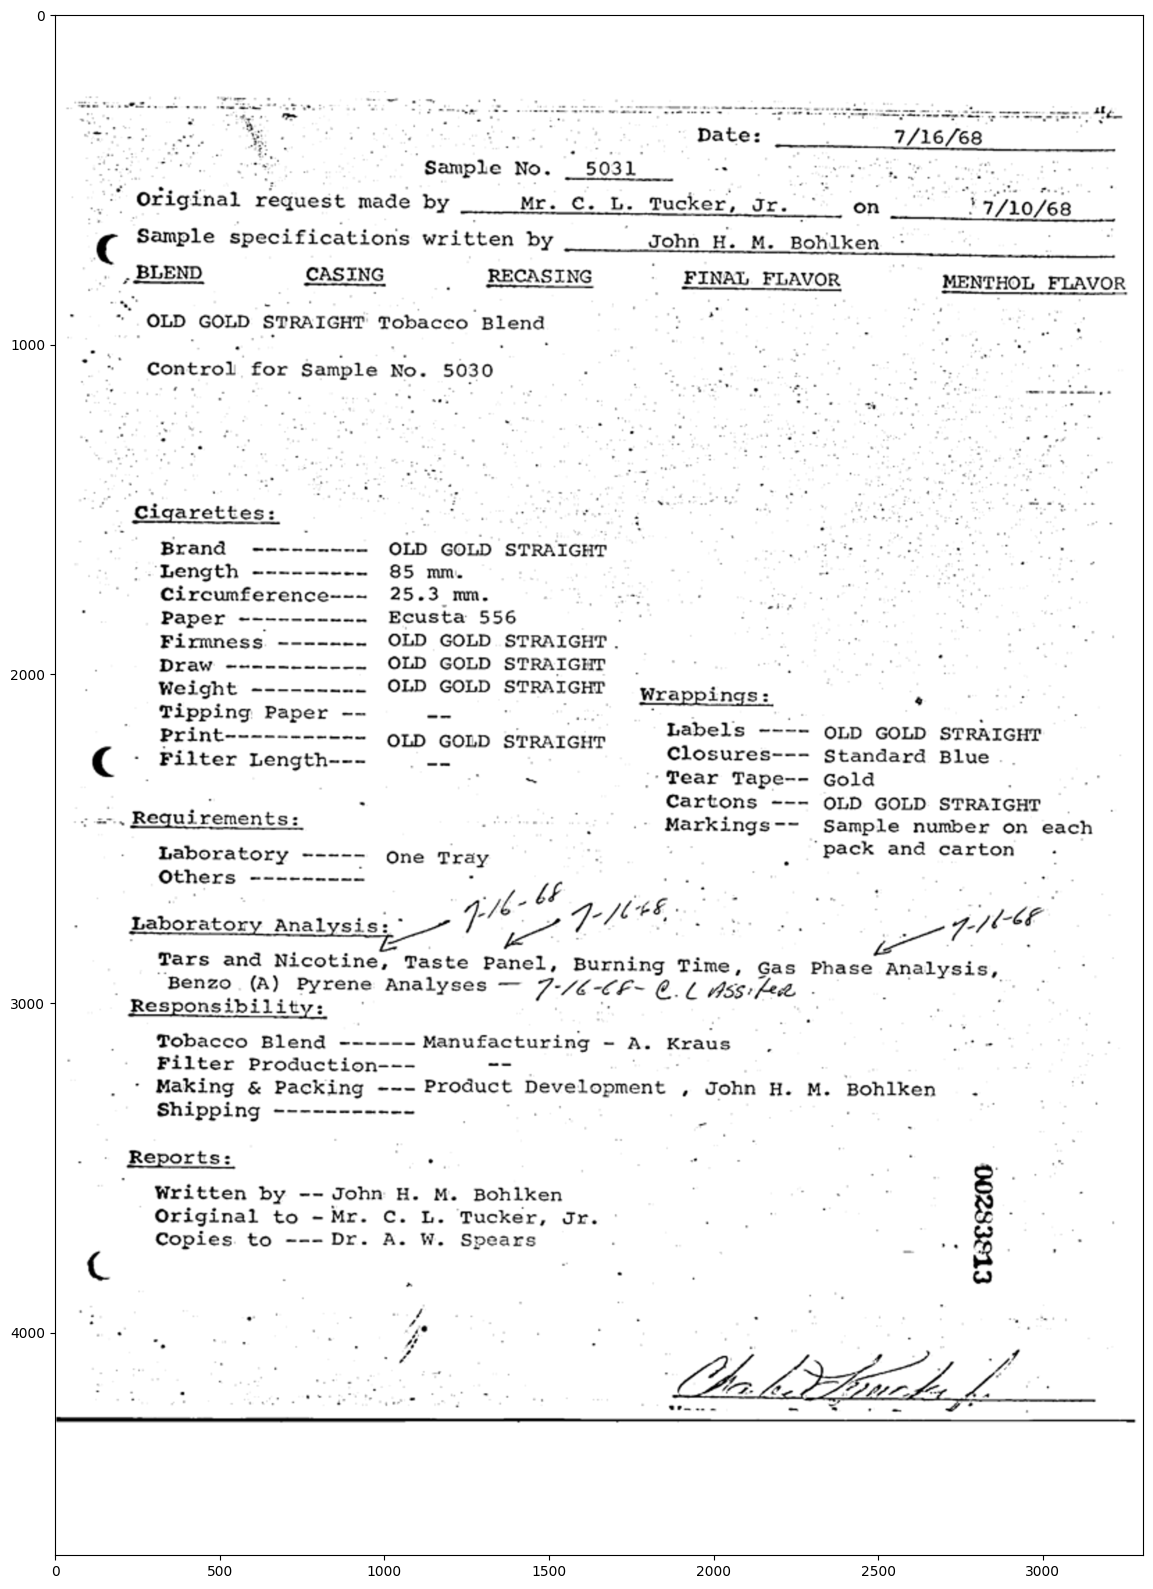

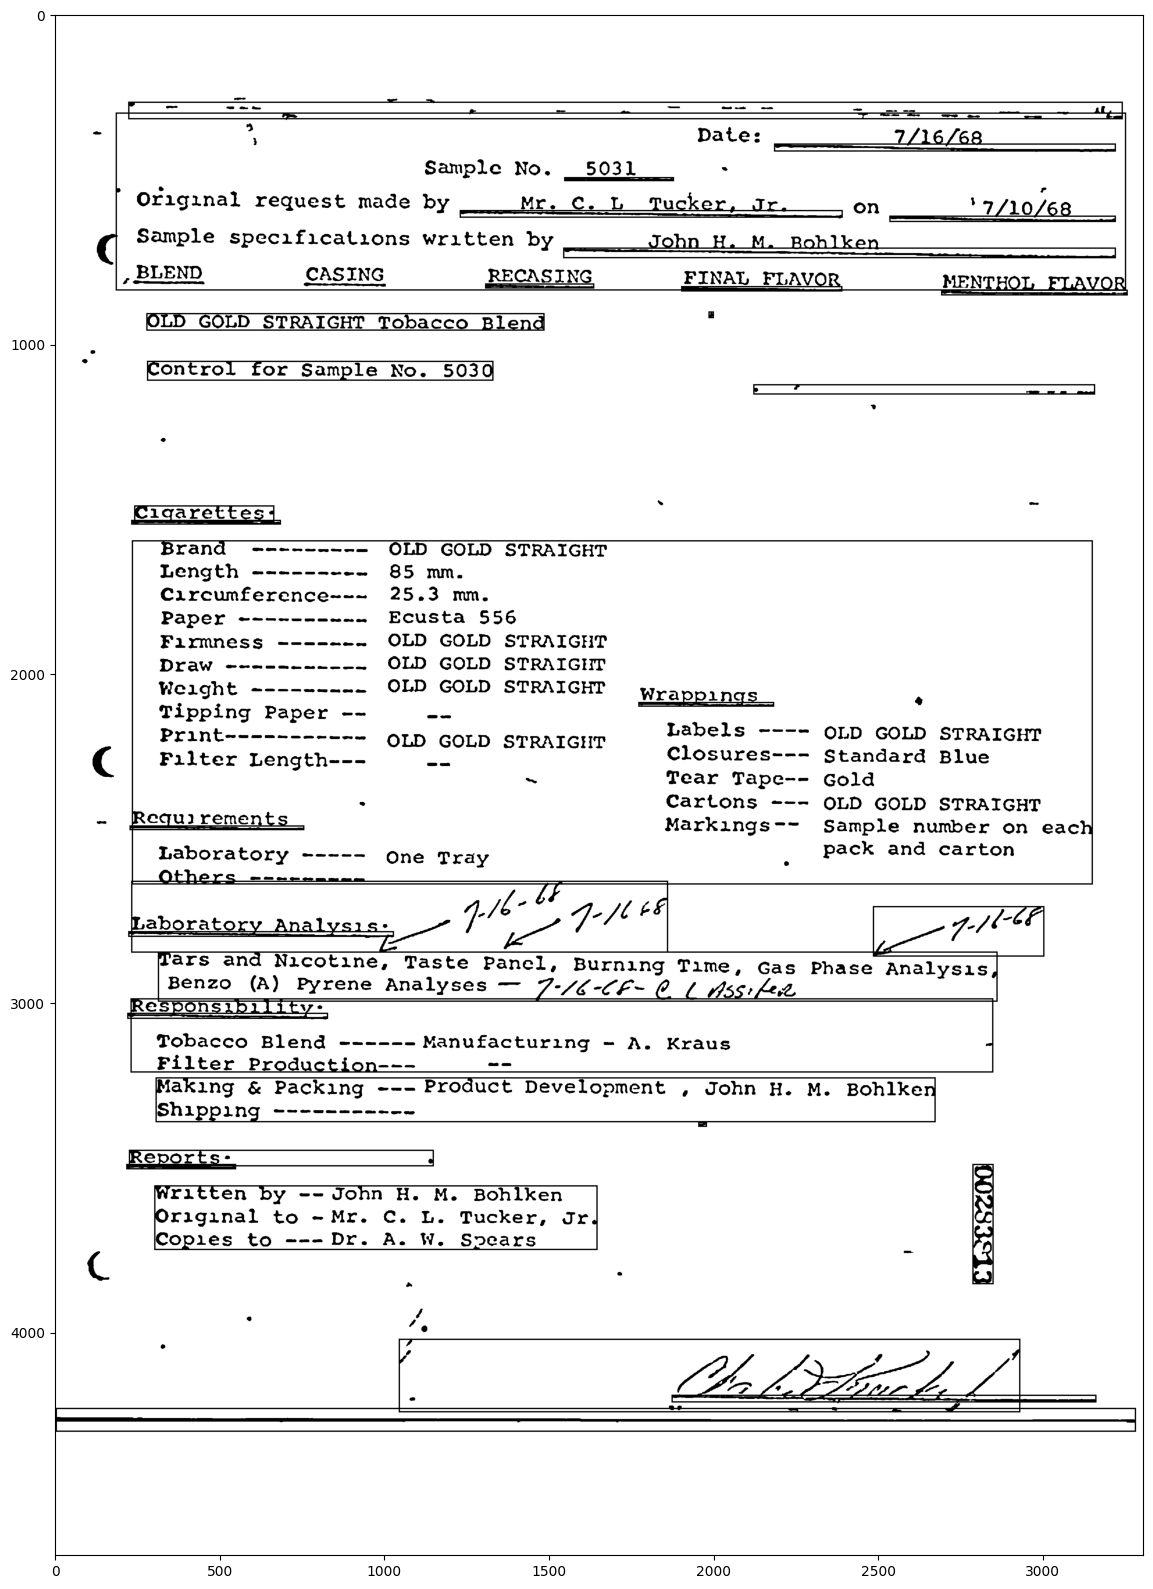

In [0]:
for r in result.select("path","image","image_with_regions").distinct().collect():
    
    print("Original: %s" % r.path)
    img = r.image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    print("Corrected: %s" % r.path)
    img = r.image_with_regions
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    plt.show()

# Image (or Natural Scene) to Text

In [0]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/images/text_with_noise.png
dbutils.fs.cp("file:/databricks/driver/text_with_noise.png", "dbfs:/")

True

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/natural_scene.jpeg
dbutils.fs.cp("file:/databricks/driver/natural_scene.jpeg", "dbfs:/")

True

## Text from Scene

## Read DOCX document as binary file

# DOCX Processing (version 1.10.0)

In [0]:
image_df = spark.read.format("binaryFile").load('/text_with_noise.png').cache()

# Read binary as image
binary_to_image = visual.BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = visual.ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = visual.ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(71)
binarizer.setOffset(65)

remove_objects = visual.ImageRemoveObjects()
remove_objects.setInputCol("binarized_image")
remove_objects.setOutputCol("cleared_image")
remove_objects.setMinSizeObject(400)
remove_objects.setMaxSizeObject(4000)

# Run OCR
ocr = visual.ImageToText()
ocr.setInputCol("cleared_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
noisy_pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    ocr
])


result = noisy_pipeline \
.transform(image_df) \
.cache()




Original: dbfs:/text_with_noise.png
Binarized
Removing objects


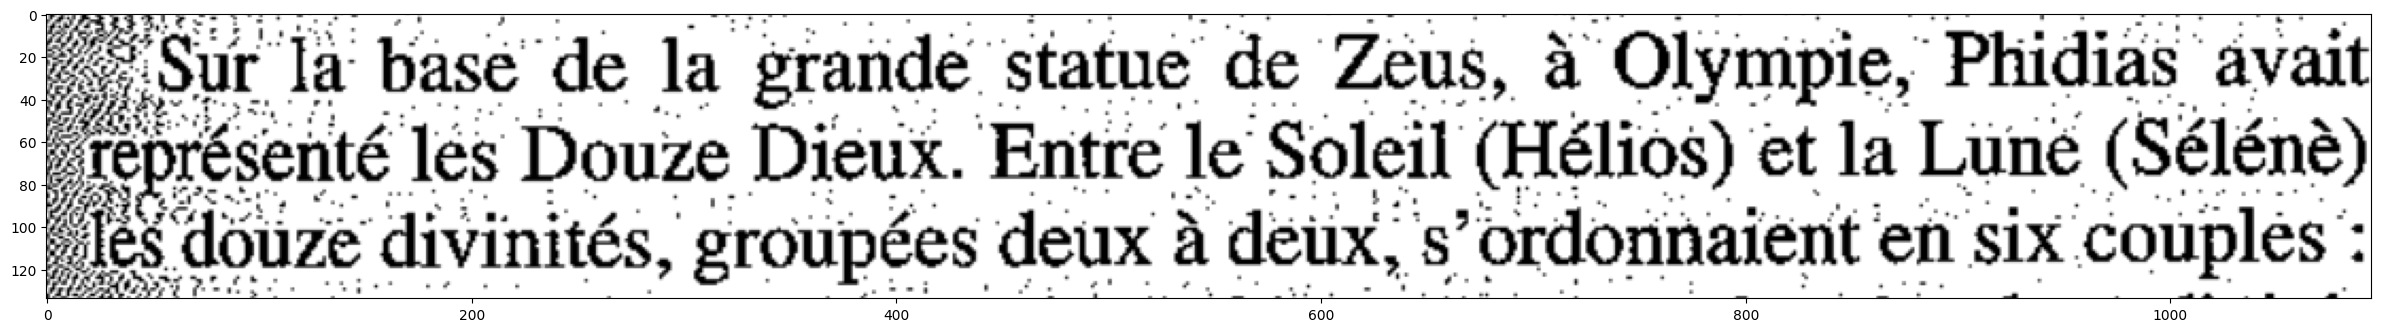

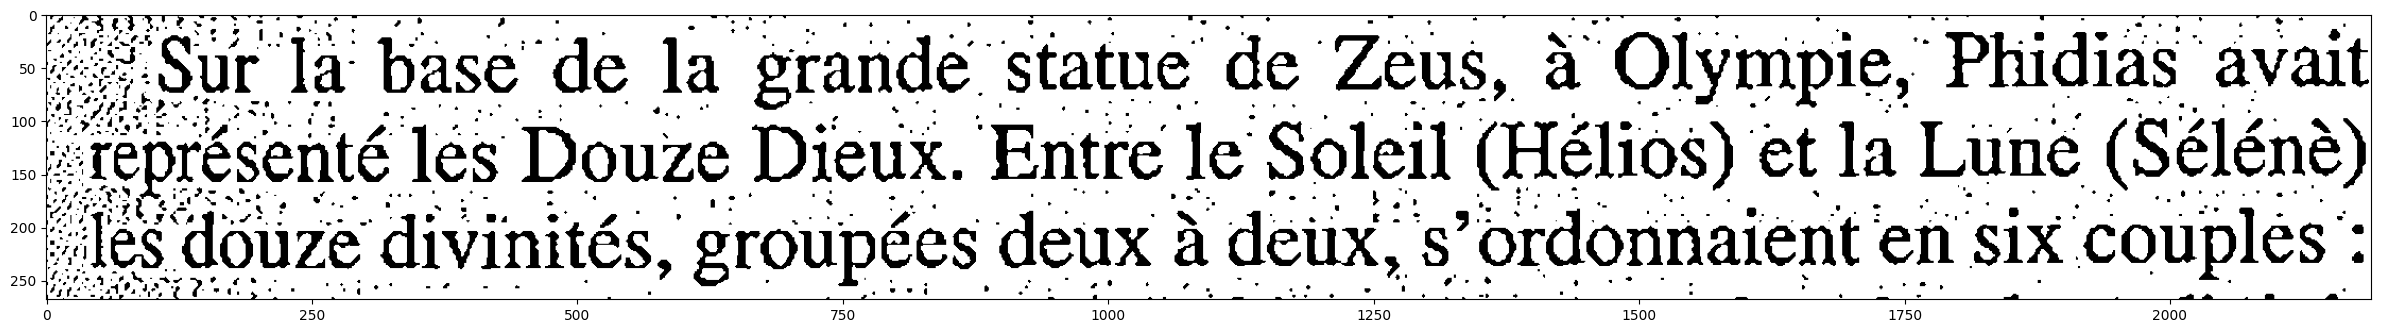

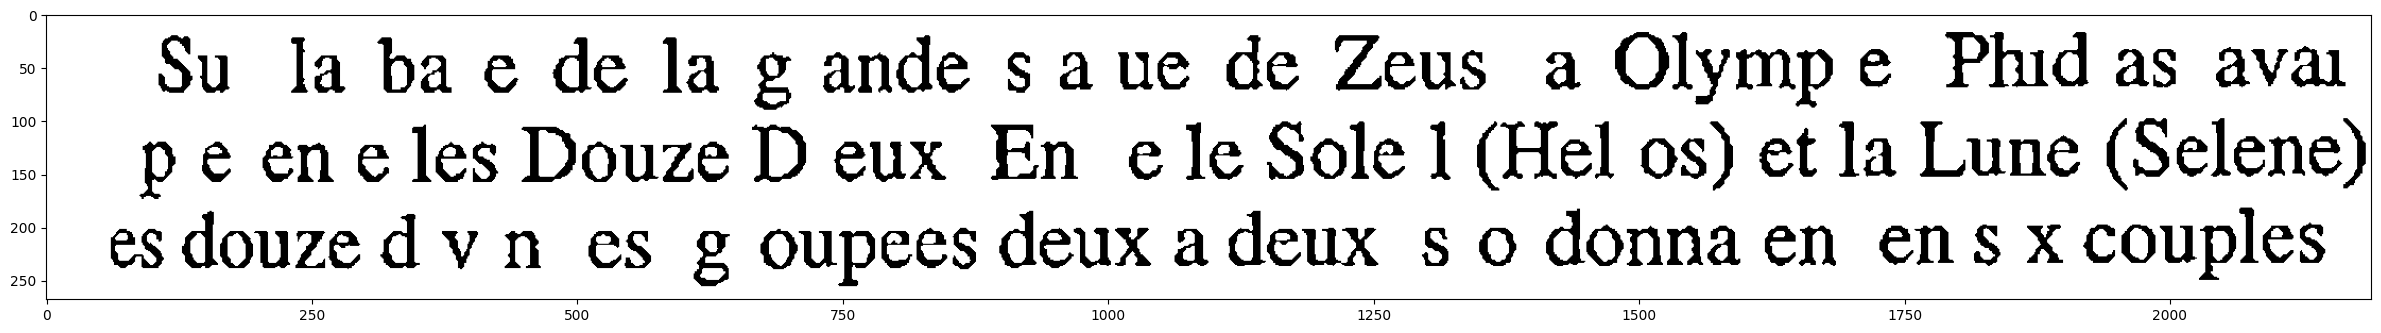

In [0]:
for r in result.distinct().collect():
  
    print("Original: %s" % r.path)
    img = r.image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    print("Binarized")
    img = r.binarized_image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
  
    print("Removing objects")
    img = r.cleared_image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(30,20))
    plt.imshow(img_pil, cmap='gray')
    
    
    plt.show()

In [0]:
print("\n".join([row.text for row in result.select("text").collect()]))

Su la ba e de la g ande saue de Zeus a Olympe Phid as avai
pe ene les Douze D eux En ele Sole | (Hel os) et la Lune (Selene)
esdouze dv n es g oupees deux adeux s o donna en ens x couples



In [0]:
import pkg_resources
doc_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/docs/doc2.docx')
dbfs_doc_path = "/doc2.docx"
dbutils.fs.cp("file:" + doc_path, dbfs_doc_path)

True

In [0]:
doc_example_df = spark.read.format("binaryFile").load(dbfs_doc_path).cache()

In [0]:
doc_example_df.show()

+---------------+-------------------+------+--------------------+
|           path|   modificationTime|length|             content|
+---------------+-------------------+------+--------------------+
|dbfs:/doc2.docx|2023-11-01 09:35:00| 33260|[50 4B 03 04 14 0...|
+---------------+-------------------+------+--------------------+



## DocxtoText

In [0]:
image_df = spark.read.format("binaryFile").load('/natural_scene.jpeg').cache()

# Apply morphology opening
morpholy_operation = visual.ImageMorphologyOperation()
morpholy_operation.setKernelShape(KernelShape.DISK)
morpholy_operation.setKernelSize(5)
morpholy_operation.setOperation("closing")
morpholy_operation.setInputCol("cleared_image")
morpholy_operation.setOutputCol("corrected_image")

# Run OCR
ocr = visual.ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
scene_pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    morpholy_operation,
    ocr
])

result = scene_pipeline \
.transform(image_df) \
.cache()

Original: dbfs:/natural_scene.jpeg
Binarized
Removing objects
Morphology closing


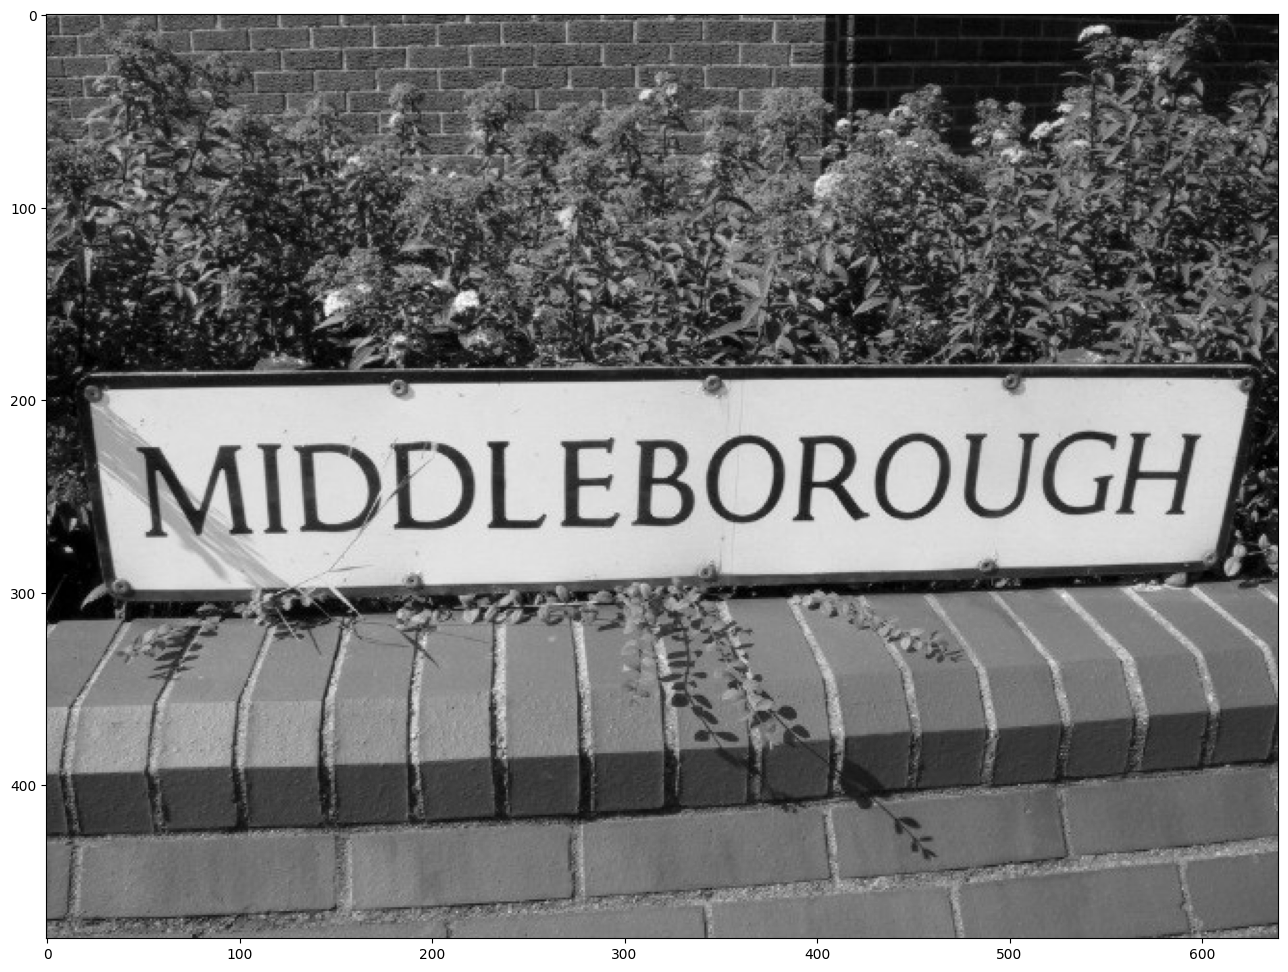

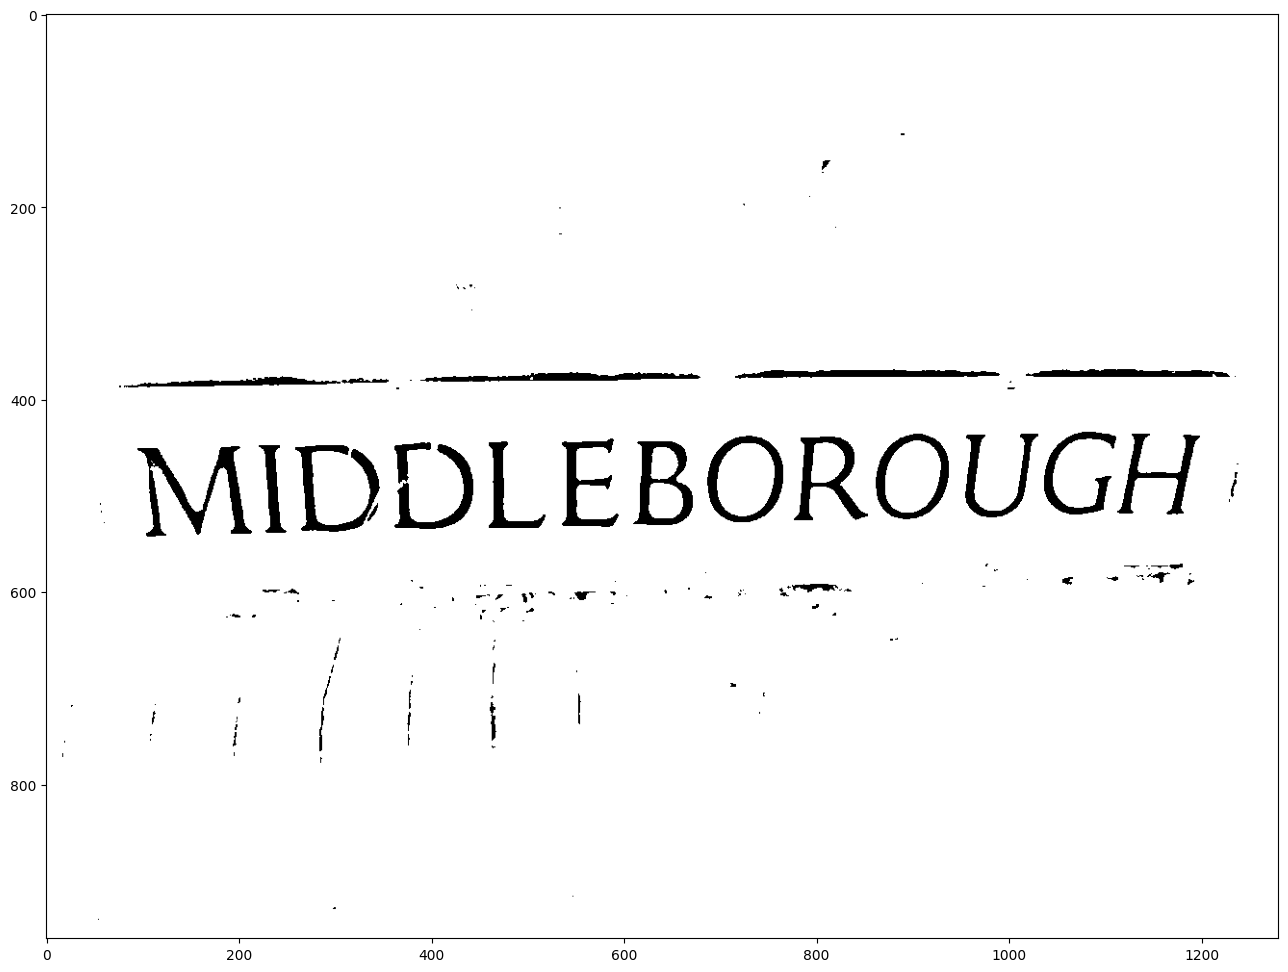

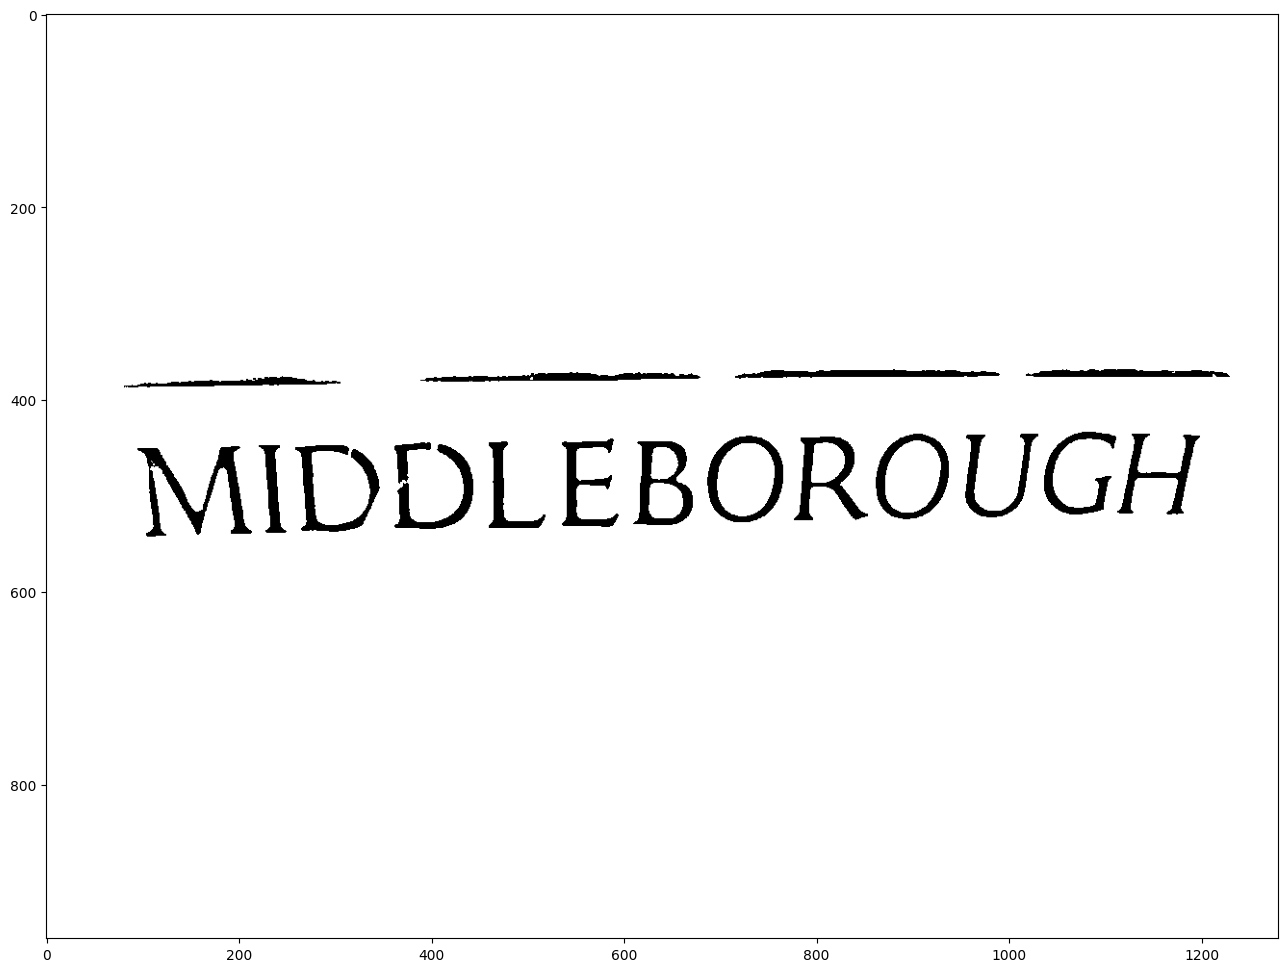

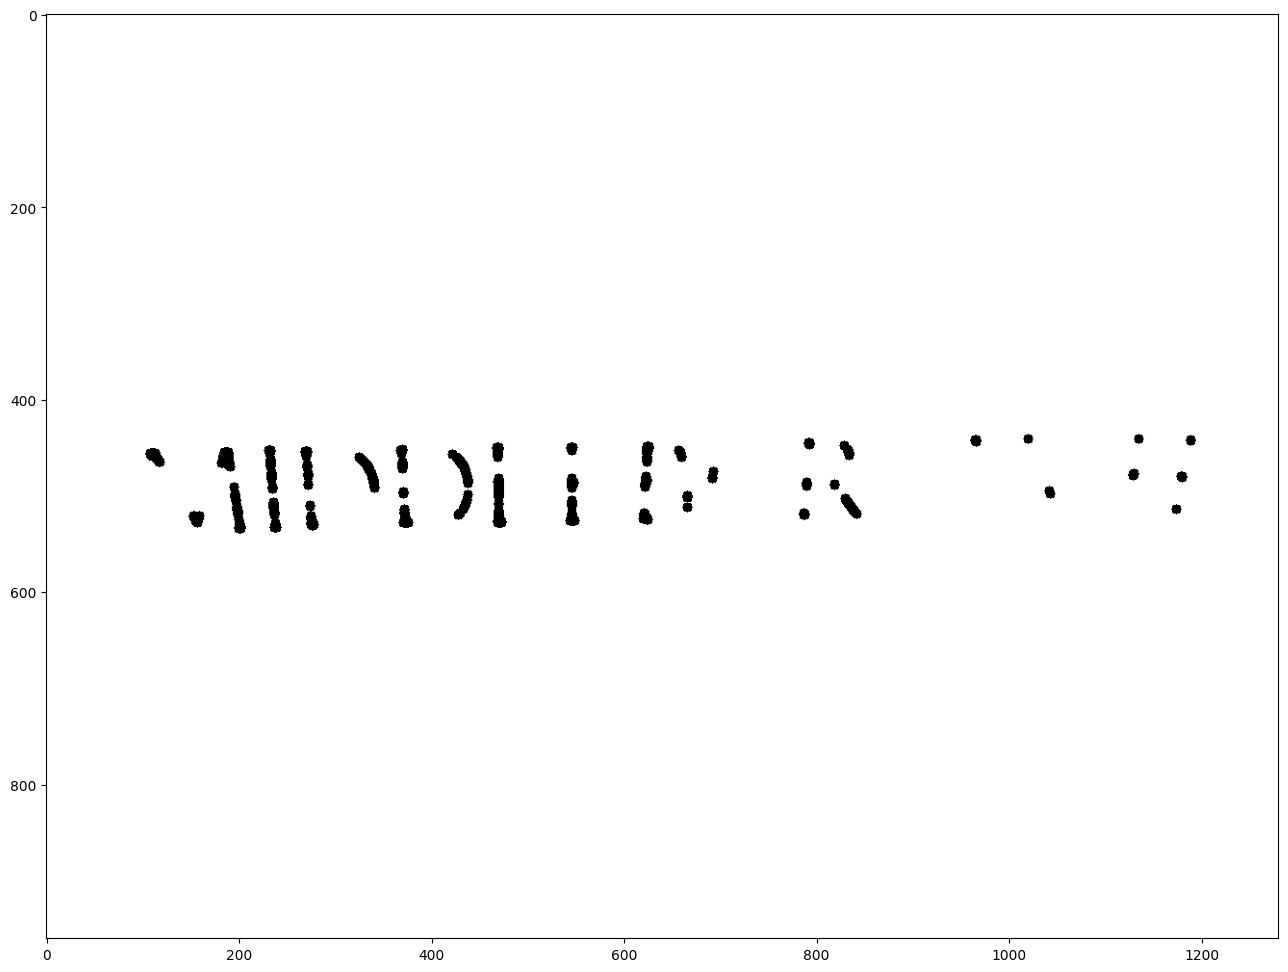

In [0]:
for r in result.distinct().collect():
      
    print("Original: %s" % r.path)
    img = r.image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(20,12))
    plt.imshow(img_pil, cmap='gray')
    
    print("Binarized")
    img = r.binarized_image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(20,12))
    plt.imshow(img_pil, cmap='gray')
  
    print("Removing objects")
    img = r.cleared_image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(20,12))
    plt.imshow(img_pil, cmap='gray')
    
    print("Morphology closing")
    img = r.corrected_image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(20,12))
    plt.imshow(img_pil, cmap='gray')
    
    
    plt.show()

### Extract text using DocToText transformer

In [0]:
#from sparkocr.transformers import *

doc_to_text = visual.DocToText()
doc_to_text.setInputCol("content")
doc_to_text.setOutputCol("text")

result = doc_to_text.transform(doc_example_df)

### Display result DataFrame

In [0]:
result.show()

+---------------+-------------------+------+--------------------+---------+-------+
|           path|   modificationTime|length|                text|exception|pagenum|
+---------------+-------------------+------+--------------------+---------+-------+
|dbfs:/doc2.docx|2023-11-01 09:35:00| 33260|Sample Document\n...|     NULL|      0|
+---------------+-------------------+------+--------------------+---------+-------+



### Display extracted text

In [0]:
print("\n".join([row.text for row in result.select("text").collect()]))

Sample Document
This document was created using accessibility techniques for headings, lists, image alternate text, tables, and columns. It should be completely accessible using assistive technologies such as screen readers.
Headings
There are eight section headings in this document. At the beginning, "Sample Document" is a level 1 heading. The main section headings, such as "Headings" and "Lists" are level 2 headings. The Tables section contains two sub-headings, "Simple Table" and "Complex Table," which are both level 3 headings.
Lists
The following outline of the sections of this document is an ordered (numbered) list with six items. The fifth item, "Tables," contains a nested unordered (bulleted) list with two items.
Headings 
Lists 
Links 
Images 
Tables 
Simple Tables 
Complex Tables 
Columns 
Links
In web documents, links can point different locations on the page, different pages, or even downloadable documents, such as Word documents or PDFs:
Top of this Page
Sample Document
Sa

## DocxToTextTable
### (Extracting table data from Microsoft DOCX documents)

### Preview document using DocToPdf and PdfToImage transformers

Original: dbfs:/doc2.docx
Original: dbfs:/doc2.docx
Original: dbfs:/doc2.docx


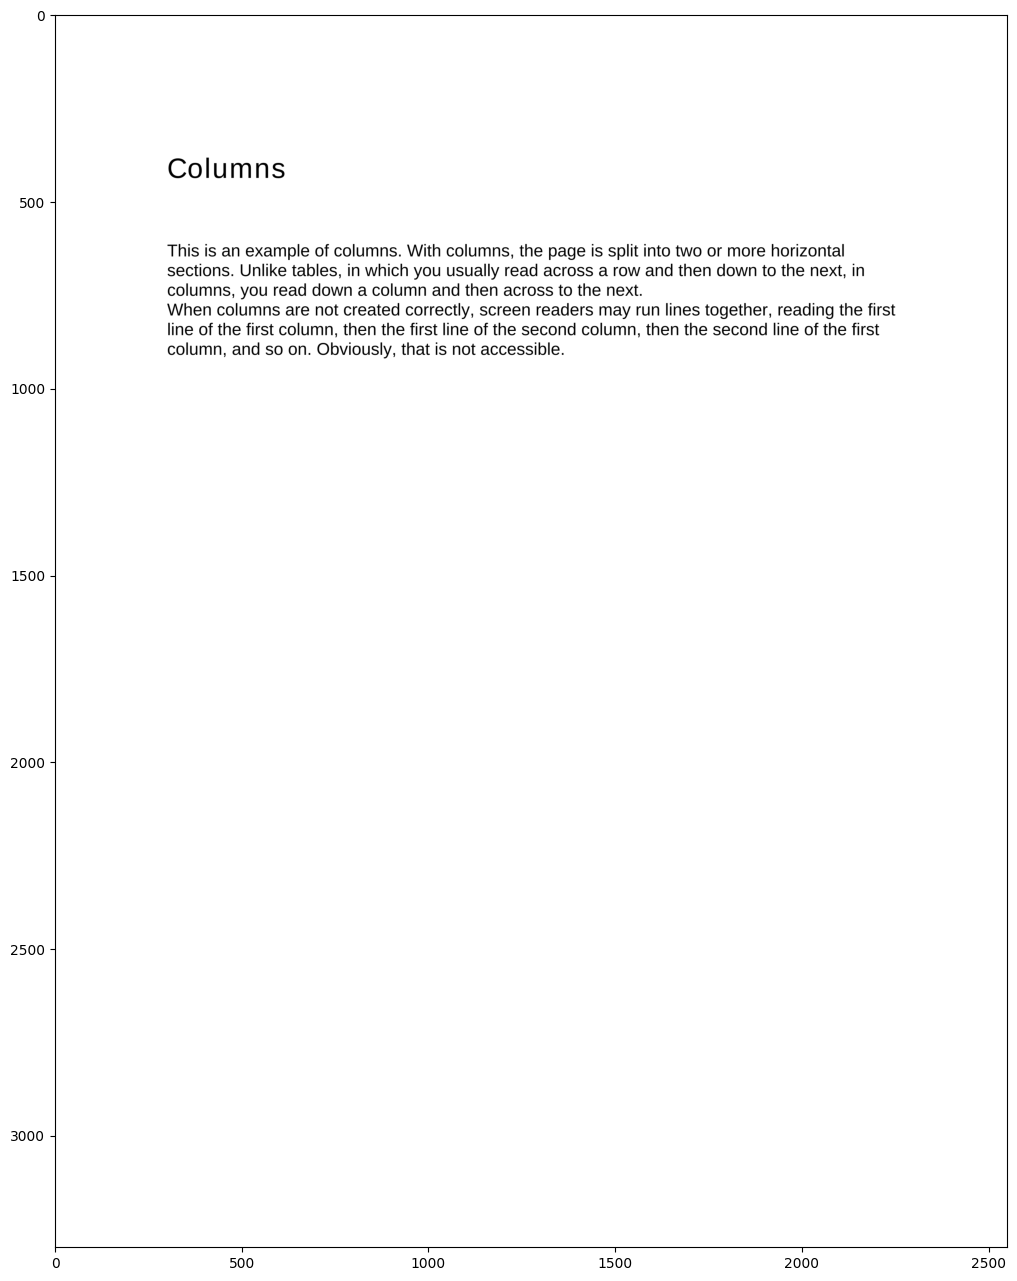

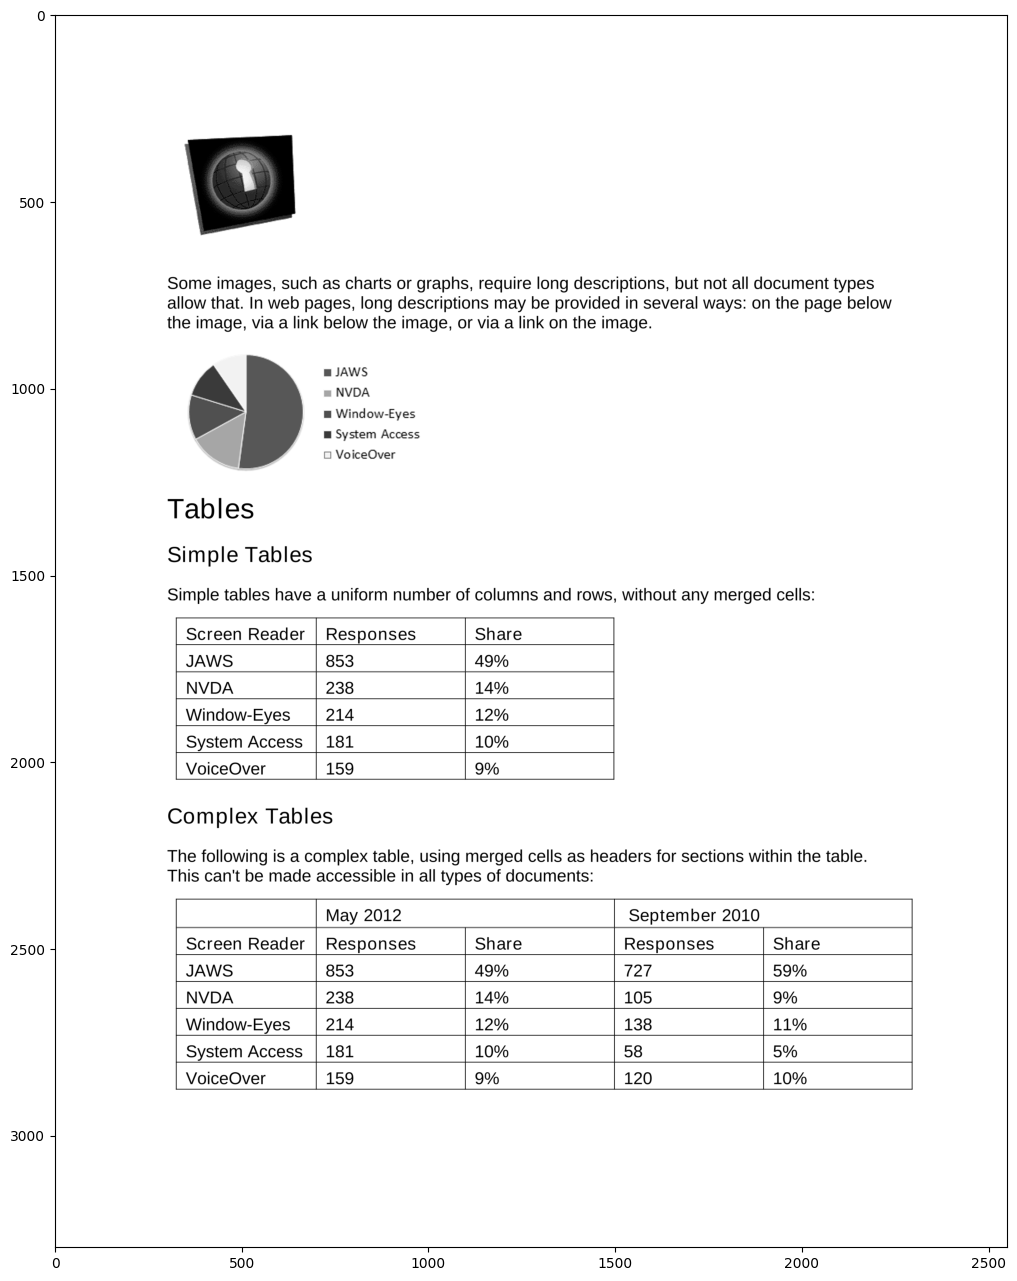

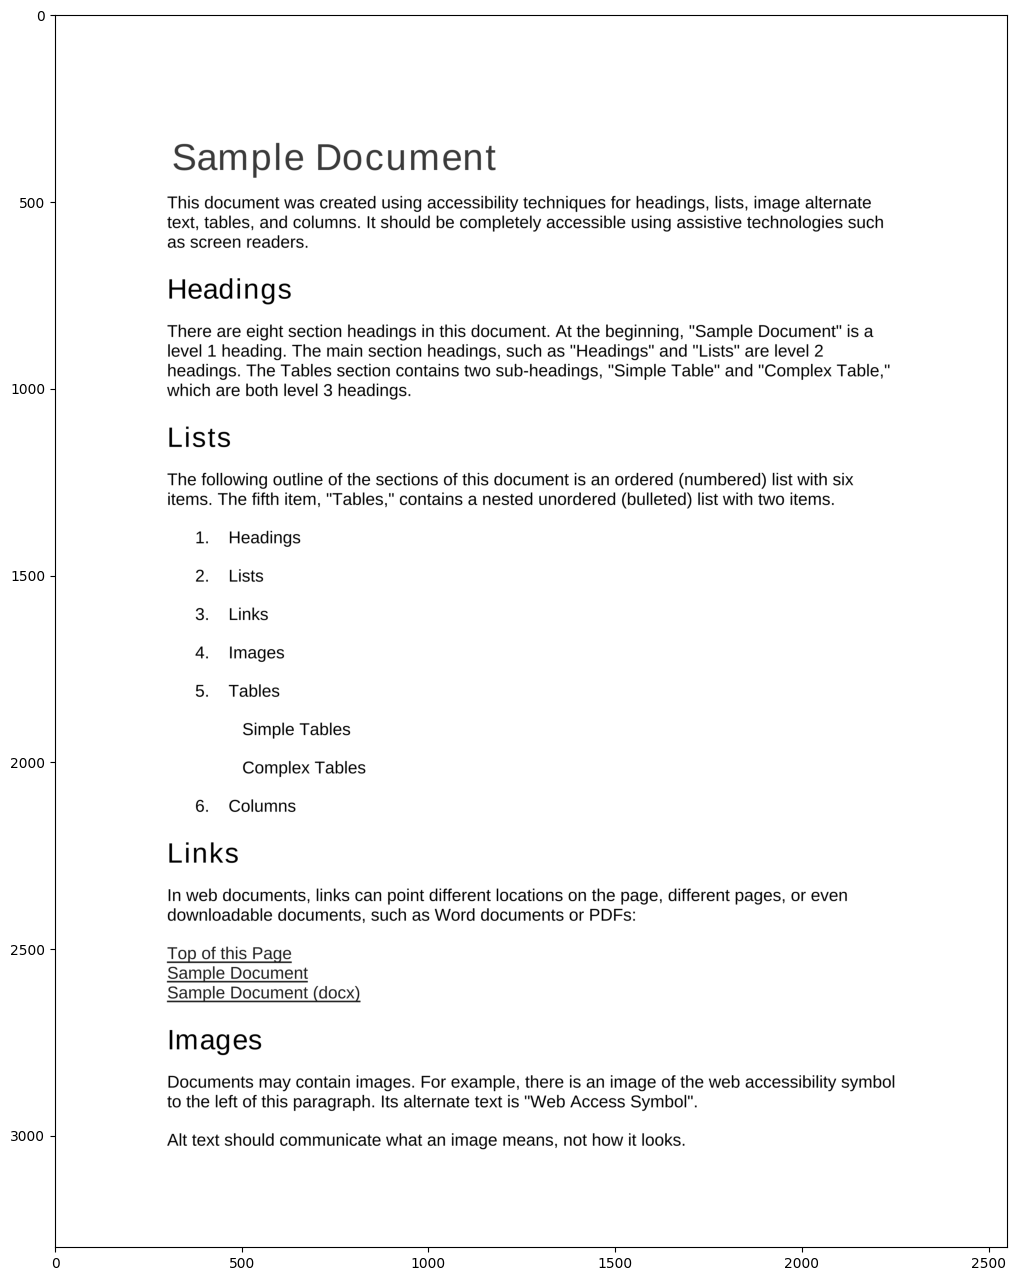

In [0]:
image_df = visual.PdfToImage().transform(visual.DocToPdf().setOutputCol("content").transform(doc_example_df))

for r in image_df.distinct().collect():
      
    print("Original: %s" % r.path)
    img = r.image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(24,16))
    plt.imshow(img_pil, cmap='gray')

### Extract text using DocToText transformer

In [0]:
doc_to_table = visual.DocToTextTable()
doc_to_table.setInputCol("content")
doc_to_table.setOutputCol("tables")

result = doc_to_table.transform(doc_example_df)

result.show()

+---------------+-------------------+------+--------------------+---------+
|           path|   modificationTime|length|              tables|exception|
+---------------+-------------------+------+--------------------+---------+
|dbfs:/doc2.docx|2023-11-01 09:35:00| 33260|{{0, 0, 0.0, 0.0,...|     NULL|
|dbfs:/doc2.docx|2023-11-01 09:35:00| 33260|{{1, 0, 0.0, 0.0,...|     NULL|
+---------------+-------------------+------+--------------------+---------+



In [0]:
result.select(result["tables.chunks"].getItem(3)["chunkText"]).show(truncate=False)

+-----------------------------------------+
|tables.chunks AS chunks#9933[3].chunkText|
+-----------------------------------------+
|[Window-Eyes, 214, 12%]                  |
|[NVDA, 238, 14%, 105, 9% ]               |
+-----------------------------------------+



### Display extracted data in JSON format

In [0]:
import json
df_json = result.select("tables").toJSON()
for row in df_json.collect():
    print(json.dumps(json.loads(row), indent=4))

{
    "tables": {
        "area": {
            "index": 0,
            "page": 0,
            "x": 0.0,
            "y": 0.0,
            "width": 0.0,
            "height": 0.0,
            "score": 0.0,
            "label": "0",
            "angle": 0.0
        },
        "chunks": [
            [
                {
                    "chunkText": "Screen Reader",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 90.0,
                    "height": 0.0
                },
                {
                    "chunkText": "Responses",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                },
                {
                    "chunkText": "Share",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                }
            ],
            [
                {
              

# Text to Pdf

In [0]:
def pipeline():
    # Transforrm PDF document to images per page
    pdf_to_image = visual.PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setKeepInput(True)
    
    # Run OCR
    ocr = visual.ImageToText() \
        .setInputCol("image") \
        .setOutputCol("text") \
        .setConfidenceThreshold(60) \
        .setIgnoreResolution(False) \
        .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)
    
    # Render results to PDF
    textToPdf = visual.TextToPdf() \
        .setInputCol("positions") \
        .setInputImage("image") \
        .setOutputCol("pdf")

    pipeline = nlp.PipelineModel(stages=[
        pdf_to_image,
        ocr,
        textToPdf
    ])
    
    return pipeline

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/test_document.pdf
dbutils.fs.cp("file:/databricks/driver/test_document.pdf", "dbfs:/")

True

In [0]:
pdf_example_df = spark.read.format("binaryFile").load('/test_document.pdf').cache()


In [0]:
result = pipeline().transform(pdf_example_df).cache()

In [0]:
result.columns

['path', 'text', 'pdf', 'exception']

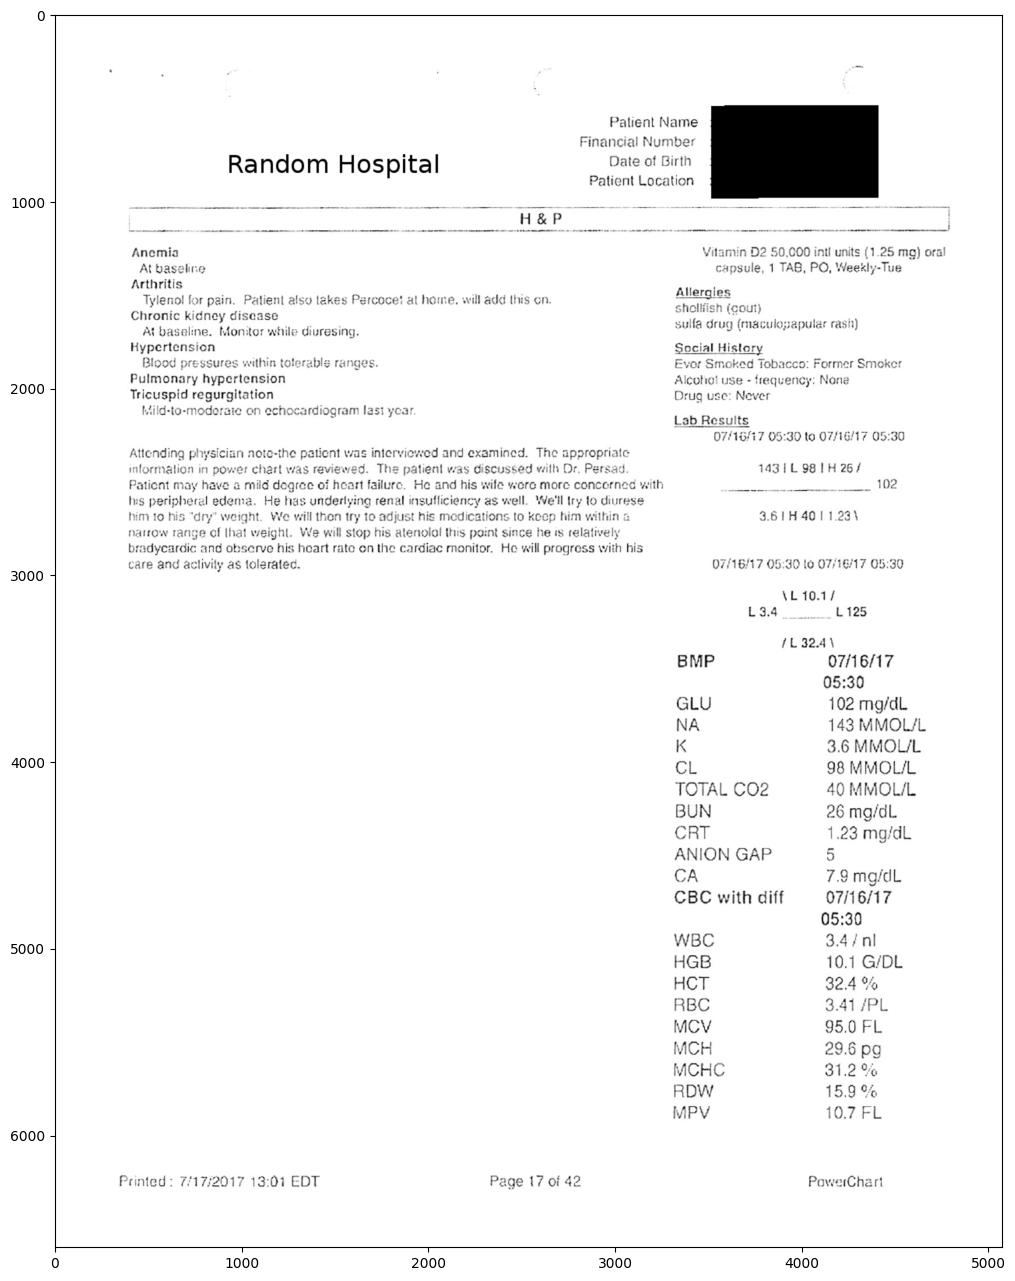

In [0]:
image_df = visual.PdfToImage().transform(pdf_example_df).select("image").collect()[0].image

img_pil = visual.to_pil_image(image_df, image_df.mode)

plt.figure(figsize=(24,16))
plt.imshow(img_pil, cmap='gray')

In [0]:
# Store results to pdf file
pdf = result.select("pdf").head().pdf

pdfFile = open("result.pdf", "wb")

pdfFile.write(pdf)

pdfFile.close()

In [0]:
# Convert pdf to image and display¶

image_df = visual.PdfToImage() \
    .setInputCol("pdf") \
    .setOutputCol("image") \
    .transform(result.select("pdf", "path"))

Original: dbfs:/test_document.pdf
Original: dbfs:/test_document.pdf


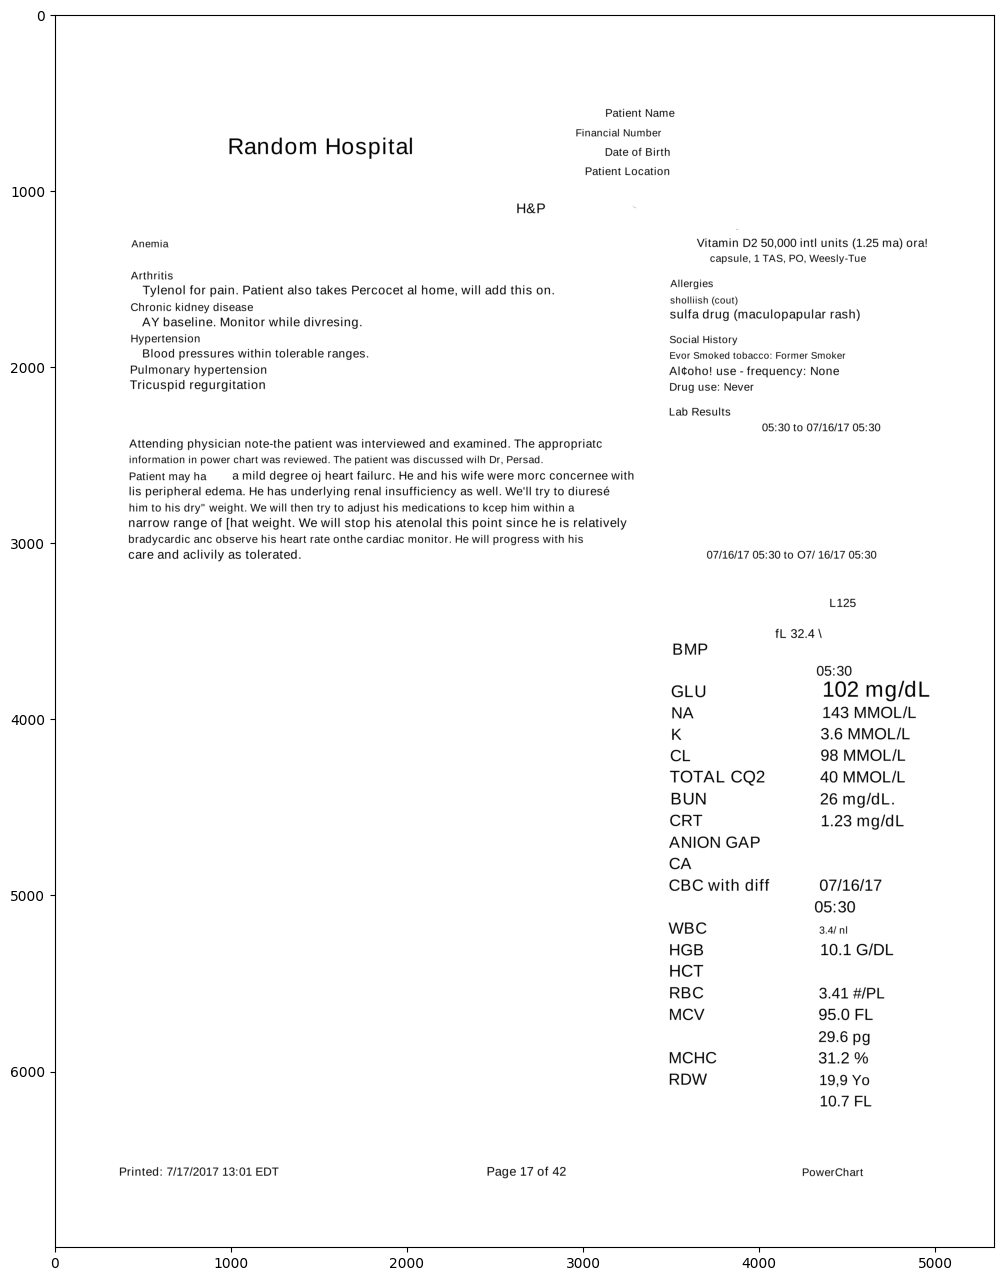

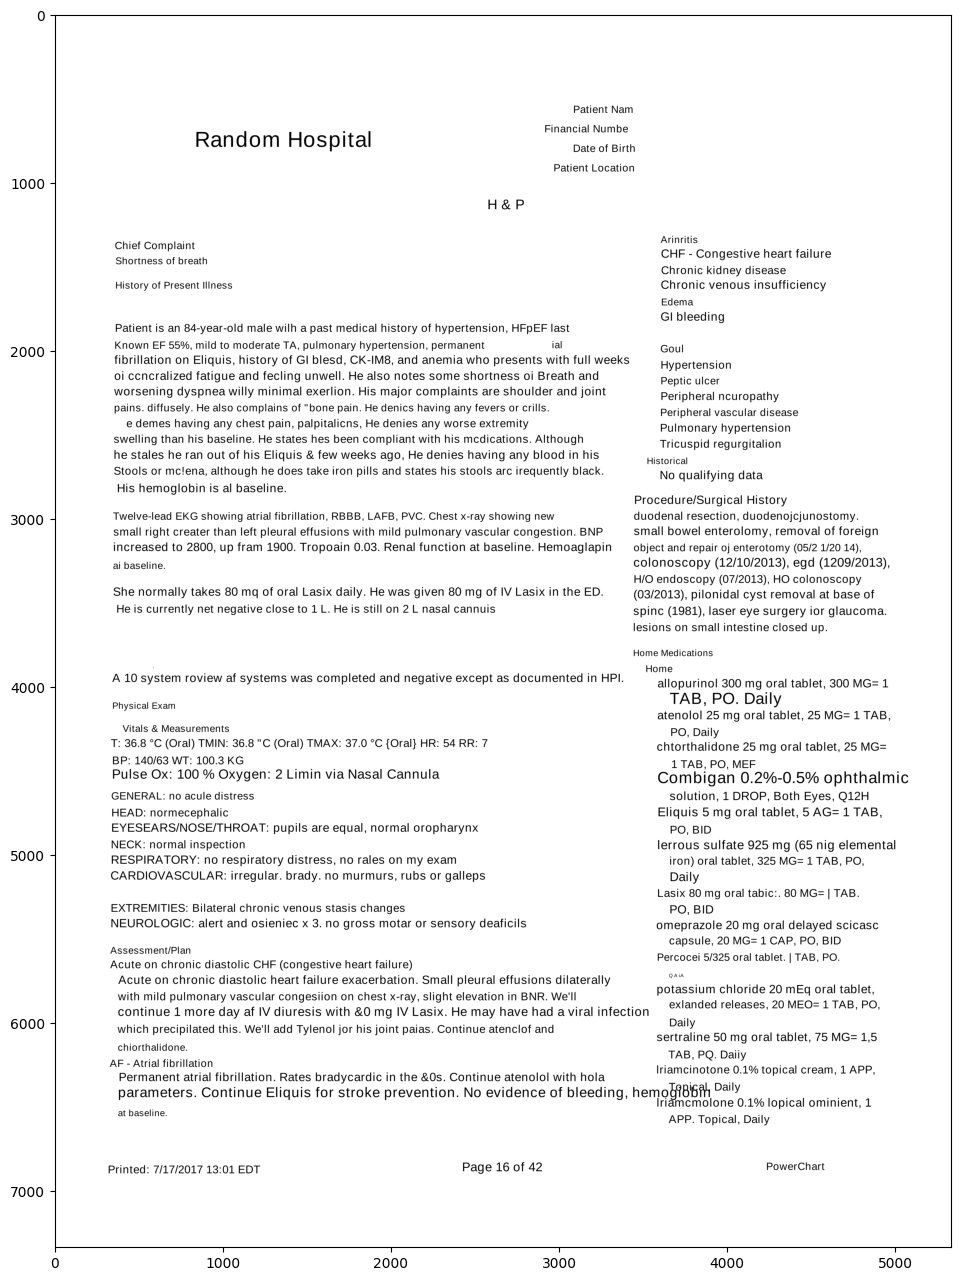

In [0]:
   
for r in image_df.distinct().collect():
      
    print("Original: %s" % r.path)
    img = r.image
    img_pil = visual.to_pil_image(img, img.mode)

    plt.figure(figsize=(24,16))
    plt.imshow(img_pil, cmap='gray')
